<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline
/
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [4]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

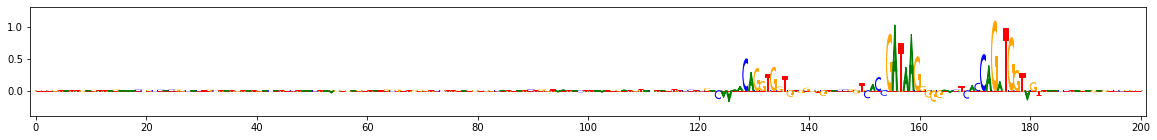

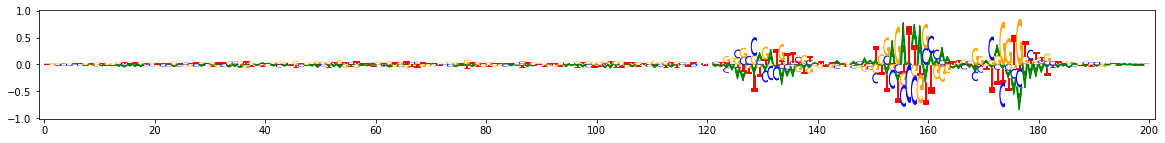

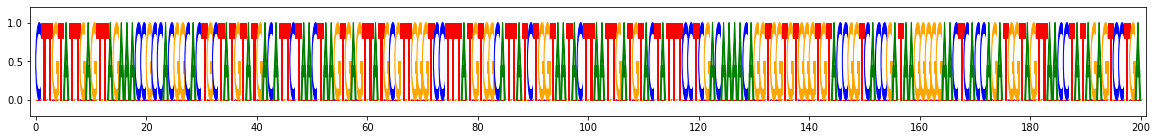

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.435310592
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Computing threshold
Thresholds from null dist were -1.0124836564064026  and  0.8997364044189453
Final raw thresholds are -1.0124836564064026  and  0.8997364044189453
Final transformed thresholds are -0.8494086021505376  and  0.8402150537634409


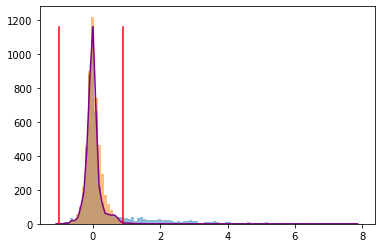

Got 198 coords
After resolving overlaps, got 198 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8401150537634409
MEMORY 0.43532288
198 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [195]
Idx to activities:  {0: '1'}
MEMORY 0.43532288
On metacluster 0
Metacluster size 195
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 195
(Round 1) Computing coarse affmat
MEMORY 0.43532288
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.09 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.455811072
Computed nearest neighbors in 0.01 s
MEMORY 0.455811072
(Round 1) Com

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5458173593205771
Quality: 0.5466752959021706


100%|██████████| 50/50 [00:01<00:00, 48.25it/s]

Got 7 clusters after round 1
Counts:
{6: 3, 5: 6, 2: 39, 1: 46, 3: 14, 0: 72, 4: 11}
MEMORY 0.45725696
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.45725696
Aggregating for cluster 0 with 72 seqlets
MEMORY 0.45725696


Trimming eliminated 0 seqlets out of 72
Skipped 6 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 1 with 46 seqlets
MEMORY 0.45725696
Trimming eliminated 0 seqlets out of 46
Skipped 7 seqlets
Removed 2 duplicate seqlets
Aggregating for cluster 2 with 39 seqlets
MEMORY 0.45725696
Trimming eliminated 0 seqlets out of 39
Skipped 3 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 3 with 14 seqlets
MEMORY 0.45725696
Trimming eliminated 0 seqlets out of 14
Skipped 1 seqlets
Aggregating for cluster 4 with 11 seqlets
MEMORY 0.45725696
Trimming eliminated 0 seqlets out of 11
Skipped 2 seqlets
Aggregating for cluster 5 with 6 seqlets
MEMORY 0.45725696
Trimming eliminated 0 seqlets out of 6
Aggregating for cluster 6 with 3 seqlets
MEMORY 0.45725696
Trimming eliminated 0 seqlets out of 3
(Round 2) num seqlets: 168
(Round 2) Computing coarse affmat
MEMORY 0.45725696
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.07 s
Starting affinity

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5373020616842145
Quality: 0.5405536843632467
Quality: 0.5408524938452323


100%|██████████| 50/50 [00:00<00:00, 53.22it/s]

Got 5 clusters after round 2
Counts:
{0: 72, 3: 4, 1: 48, 2: 41, 4: 3}
MEMORY 0.461856768
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.461856768
Aggregating for cluster 0 with 72 seqlets
MEMORY 0.461856768


Trimming eliminated 0 seqlets out of 72
Aggregating for cluster 1 with 48 seqlets
MEMORY 0.461856768
Trimming eliminated 0 seqlets out of 48
Aggregating for cluster 2 with 41 seqlets
MEMORY 0.461856768
Trimming eliminated 0 seqlets out of 41
Removed 1 duplicate seqlets
Aggregating for cluster 3 with 4 seqlets
MEMORY 0.461856768
Trimming eliminated 0 seqlets out of 4
Removed 1 duplicate seqlets
Aggregating for cluster 4 with 3 seqlets
MEMORY 0.461856768
Trimming eliminated 0 seqlets out of 3
Removed 1 duplicate seqlets
Got 5 clusters
Splitting into subclusters...
MEMORY 0.461856768
Inspecting for spurious merging
Wrote graph to binary file in 0.008711814880371094 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00267138
After 2 runs, maximum modularity is Q = 0.00268151
Louvain completed 22 runs in 0.2644789218902588 seconds
Similarity is 0.9601754; is_dissimilar is False
Merging on 5 clusters
MEMORY 0.4619264
On merging iteration 1
Numbers for e

In [13]:
import h5py
import numpy as np
%matplotlib inline
import modisco

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0"],# "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [14]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


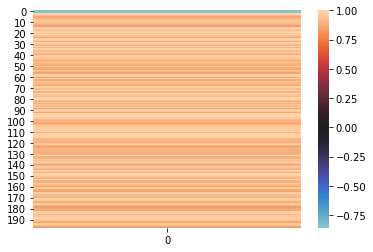

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 82
Task 0 hypothetical scores:


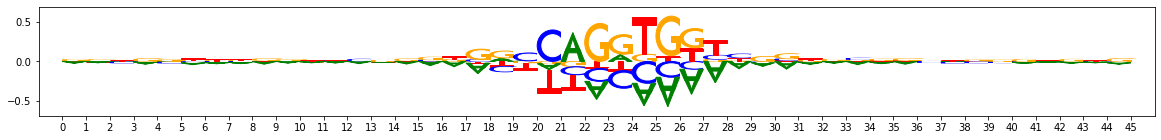

Task 0 actual importance scores:


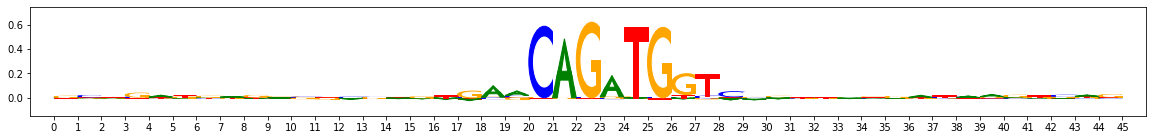

onehot, fwd and rev:


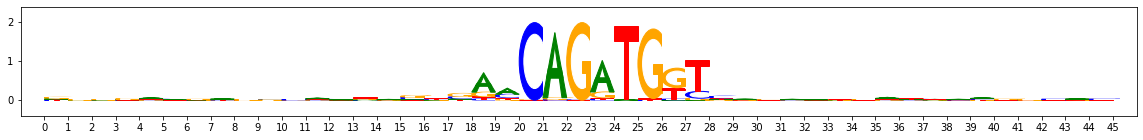

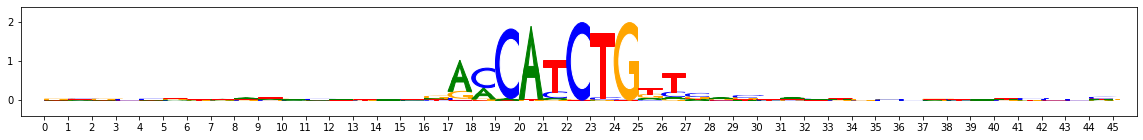

metacluster_0 pattern_1
total seqlets: 75
Task 0 hypothetical scores:


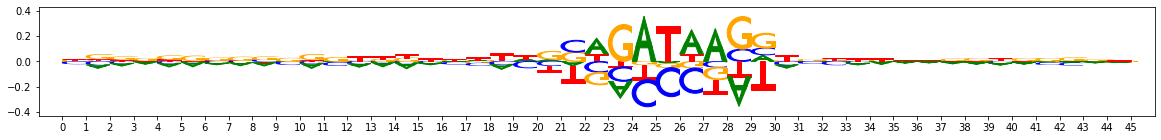

Task 0 actual importance scores:


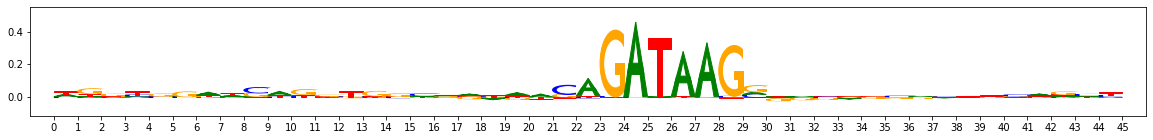

onehot, fwd and rev:


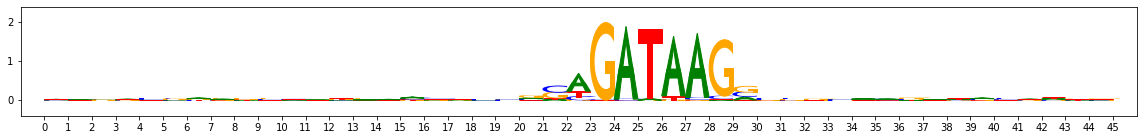

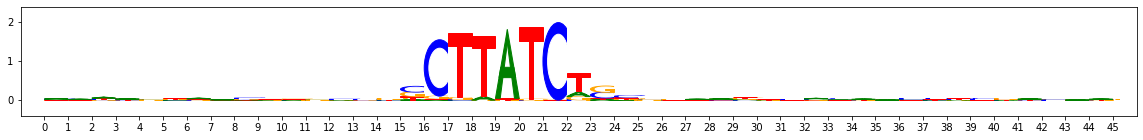

In [16]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [17]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Getting the exemplar motifs
Numseqles: 82


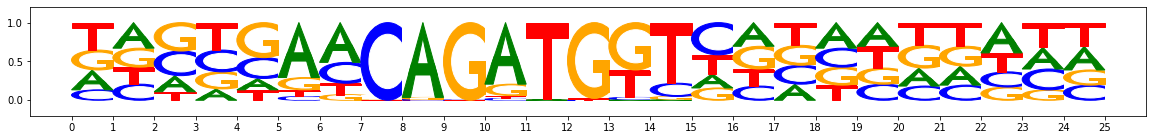

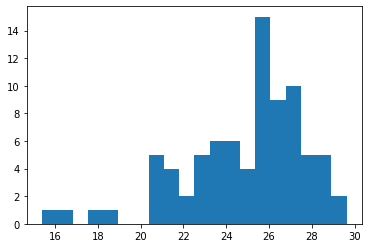

After filtering: numseqlets 82


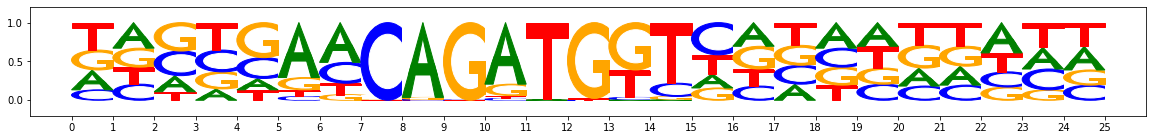

Numseqles: 75


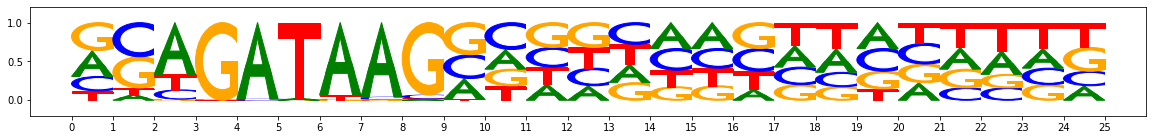

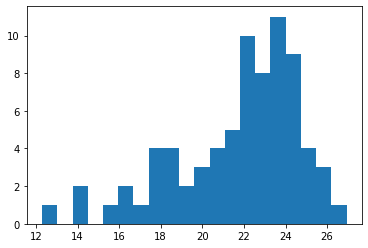

After filtering: numseqlets 74


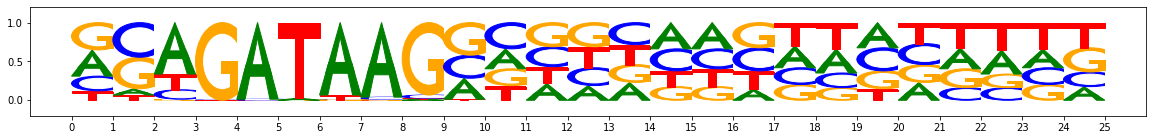

Getting labels
Getting impscores data
Computing fwd sims
Took 0.113922119140625 s


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Getting impscores data


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.1s finished


Computing fwd sims
Took 0.12588191032409668 s


In [42]:
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

instance_scorer = exemplar_based_hitscoring.prepare_instance_scorer(
    patterns=(loaded_tfmodisco_results
                .metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns),
    trim_window_size=25,
    task_names=tasks,
    bg_freq=background,
    track_set=track_set)

In [43]:
instance_scorer.precrecthres_list

[(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  array([1.        , 0.98780488, 0.97560976, 0.96341463, 0.95121951,
         0.93902439, 0.92682927, 0.91463415, 0.90243902, 0.8902439 ,
         0.87804878, 0.86585366, 0.85365854, 0.84146341, 0.82926829,
         0.81707317, 0.80487805, 0.79268293, 0.7804878 , 0.76829268,
         0.75609756, 0.74390244, 0.73170732, 0.7195122 , 0.70731707,
         0.69512195, 0.68292683, 0.67073171, 0.65853659, 0.64634146,
         0.63414634, 0.62195122, 0.6097561 , 0.59756098, 0.58536585,
         0.57317073, 0.56097561, 0.54878049, 0.53658537, 0.52439024,
         0.51219512, 0.5       , 0.48780488, 0.47560976, 0.46341463,
